In [14]:
# for numbers
import numpy as np
import pandas as pd

# for visualization
import matplotlib.pyplot as plt
import seaborn as sns 

import os
# parsing xml
import xml.etree.ElementTree as ET
# for search files using patterns
import glob

# Python Imaging Library
from PIL import Image

import cv2

# for training and preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, classification_report

In [3]:
# get the path
path = os.getcwd()

In [9]:
# the paths
input_data_path = 'Data/images'
annotations_path = "./Data/annotations"
images = [*os.listdir(f'{path}/Data/images')]
output_data_path =  '.'

In [12]:
def parse_annotation(path:str) -> list:
    tree = ET.parse(path)
    root = tree.getroot()
    constants = {}
    objects = [child for child in root if child.tag == 'object']
    for element in tree.iter():
        if element.tag == 'filename':
            constants['file'] = element.text[0:-4]
        if element.tag == 'size':
            for dim in list(element):
                if dim.tag == 'width':
                    constants['width'] = int(dim.text)
                if dim.tag == 'height':
                    constants['height'] = int(dim.text)
                if dim.tag == 'depth':
                    constants['depth'] = int(dim.text)
    object_params = [parse_annotation_object(obj) for obj in objects]
    #print(constants)
    full_result = [merge(constants,ob) for ob in object_params]
    return full_result


def parse_annotation_object(annotation_object:list) -> dict:
    params = {}
    for param in list(annotation_object):
        if param.tag == 'name':
            params['name'] = param.text
        if param.tag == 'bndbox':
            for coord in list(param):
                if coord.tag == 'xmin':
                    params['xmin'] = int(coord.text)              
                if coord.tag == 'ymin':
                    params['ymin'] = int(coord.text)
                if coord.tag == 'xmax':
                    params['xmax'] = int(coord.text)
                if coord.tag == 'ymax':
                    params['ymax'] = int(coord.text)
            
    return params       
 
def merge(dict1, dict2):
    res = {**dict1, **dict2}
    return res

In [15]:
# create data
dataset = [parse_annotation(anno) for anno in glob.glob(annotations_path+"/*.xml") ]
full_dataset = sum(dataset, [])
# create dataframe
df = pd.DataFrame(full_dataset)
df.shape

(4072, 9)

In [16]:
# show head of dataframe
df.head()

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss281,301,400,3,with_mask,98,204,195,329
1,maksssksksss375,400,310,3,without_mask,259,76,277,94
2,maksssksksss375,400,310,3,without_mask,273,192,289,210
3,maksssksksss279,400,266,3,with_mask,290,80,341,135
4,maksssksksss279,400,266,3,without_mask,48,237,79,266


In [17]:
# split and select
final_test_image = 'maksssksksss0'
df_final_test = df.loc[df["file"] == final_test_image]
images.remove(f'{final_test_image}.png')
df = df.loc[df["file"] != final_test_image]

In [18]:
df

,file,width,height,depth,name,xmin,ymin,xmax,ymax
0,maksssksksss281,301,400,3,with_mask,98,204,195,329
1,maksssksksss375,400,310,3,without_mask,259,76,277,94
2,maksssksksss375,400,310,3,without_mask,273,192,289,210
3,maksssksksss279,400,266,3,with_mask,290,80,341,135
4,maksssksksss279,400,266,3,without_mask,48,237,79,266
...,...,...,...,...,...,...,...,...,...
4067,maksssksksss445,400,267,3,with_mask,240,68,264,96
4068,maksssksksss445,400,267,3,with_mask,267,62,298,97
4069,maksssksksss445,400,267,3,with_mask,332,34,350,61
4070,maksssksksss445,400,267,3,with_mask,377,39,396,62


In [19]:
# show counts
df["name"].value_counts()

with_mask                3231
without_mask              715
mask_weared_incorrect     123
Name: name, dtype: int64

Text(0, 0.5, 'name')

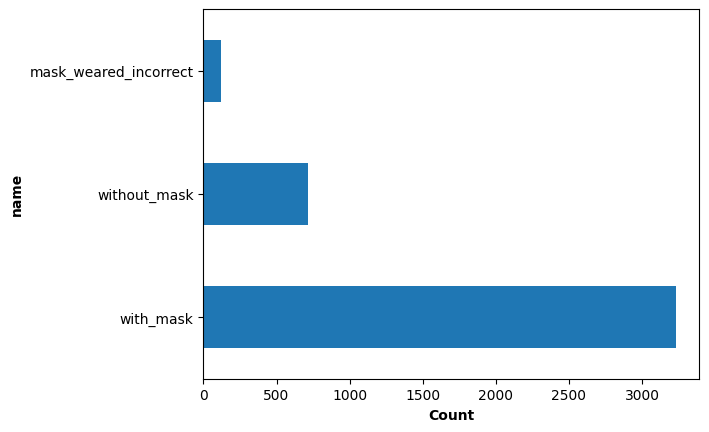

In [20]:
# plot counts 
df["name"].value_counts().plot(kind='barh')
plt.xlabel('Count', fontsize = 10, fontweight = 'bold')
plt.ylabel('name', fontsize = 10, fontweight = 'bold')

In [22]:
# create files in output file
labels = df['name'].unique()
directory = ['train', 'test', 'val']
output_data_path =  './output'

import os
for label in labels:
    for d in directory:
        path = os.path.join(output_data_path, d, label)
        if not os.path.exists(path):
            os.makedirs(path)

In [23]:
# crop face from image
def crop_img(image_path:str, x_min:int, y_min:int, x_max:int, y_max:int):
    x_shift = (x_max - x_min) * 0.1
    y_shift = (y_max - y_min) * 0.1
    img = Image.open(image_path)
    cropped = img.crop((x_min - x_shift, y_min - y_shift, x_max + x_shift, y_max + y_shift))
    return cropped

In [24]:
# extract faces from image
def extract_faces(image_name:str, image_info:pd.DataFrame) -> list:
    faces = []
    df_one_img = image_info[image_info['file'] == image_name[:-4]][['xmin', 'ymin', 'xmax', 'ymax', 'name']]
    for row_num in range(len(df_one_img)):
        x_min, y_min, x_max, y_max, label = df_one_img.iloc[row_num] 
        image_path = os.path.join(input_data_path, image_name)
        faces.append((crop_img(image_path, x_min, y_min, x_max, y_max), label,f'{image_name[:-4]}_{(x_min, y_min)}'))
    return faces

In [25]:
# crop face
cropped_faces = [extract_faces(img, df) for img in images]
flat_cropped_faces = sum(cropped_faces, [])

In [26]:
# lable == with_mask
with_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "with_mask"]
# lable == mask_weared_incorrect
mask_weared_incorrect = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "mask_weared_incorrect"]
# lable == without_mask
without_mask = [(img, image_name) for img, label,image_name in flat_cropped_faces if label == "without_mask"]

In [27]:
print(len(with_mask))
print(len(without_mask))
print(len(mask_weared_incorrect))
print(len(with_mask) + len(without_mask) + len(mask_weared_incorrect))

3231
715
123
4069


In [28]:
# train test split -> with_mask
train_with_mask, test_with_mask = train_test_split(with_mask, test_size=0.20, random_state=42)
test_with_mask, val_with_mask = train_test_split(test_with_mask, test_size=0.7, random_state=42)
# train test split -> mask_weared_incorrect
train_mask_weared_incorrect, test_mask_weared_incorrect = train_test_split(mask_weared_incorrect, test_size=0.20, random_state=42)
test_mask_weared_incorrect, val_mask_weared_incorrect = train_test_split(test_mask_weared_incorrect, test_size=0.7, random_state=42)
# train test split -> without_mask
train_without_mask, test_without_mask = train_test_split(without_mask, test_size=0.20, random_state=42)
test_without_mask, val_without_mask = train_test_split(test_without_mask, test_size=0.7, random_state=42)

In [29]:
def save_image(image:str, image_name:str, output_data_path:str,  dataset_type:str, label:str):
    output_path = os.path.join(output_data_path, dataset_type, label ,f'{image_name}.png')
    image.save(output_path)  

In [30]:
for image, image_name in train_with_mask:
    save_image(image, image_name, output_data_path, 'train', 'with_mask')

for image, image_name in train_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'train', 'mask_weared_incorrect')

for image, image_name in train_without_mask:
    save_image(image, image_name, output_data_path, 'train', 'without_mask')

###############################

for image, image_name in test_with_mask:
    save_image(image, image_name, output_data_path, 'test', 'with_mask')

for image, image_name in test_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'test', 'mask_weared_incorrect')

for image, image_name in test_without_mask:
    save_image(image, image_name, output_data_path, 'test', 'without_mask')
     
###############################
   
for image, image_name in val_with_mask:
    save_image(image, image_name, output_data_path, 'val', 'with_mask')

for image, image_name in val_without_mask:
    save_image(image, image_name, output_data_path, 'val', 'without_mask')

for image, image_name in val_mask_weared_incorrect:
    save_image(image, image_name, output_data_path, 'val', 'mask_weared_incorrect')

In [31]:
# create CNN model

# Sequential 
model = Sequential()
# Conv2D layer
model.add(Conv2D(filters = 16, kernel_size = 3,  padding='same', activation = 'relu', input_shape = (35,35,3)))
# MaxPooling2D layer
model.add(MaxPooling2D(pool_size = 2))
# Conv2D layer
model.add(Conv2D(filters = 32, kernel_size = 3,  padding='same', activation = 'relu'))
# MaxPooling2D layer
model.add(MaxPooling2D(pool_size = 2))
# Conv2D layer
model.add(Conv2D(filters = 64, kernel_size = 3,  padding='same', activation = 'relu'))
# MaxPooling2D layer
model.add(MaxPooling2D(pool_size = 2))
# Dropout layer
model.add(Dropout(0.3))
# Flatten layer
model.add(Flatten())
# Dense layer
model.add(Dense(units = 500, activation = 'relu'))
# Dropout layer
model.add(Dropout(0.3))
# Dense layer
model.add(Dense(units = 3, activation = 'softmax'))
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 35, 35, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 17, 17, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 17, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 64)          18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 64)         0

2023-02-16 21:45:43.854940: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-02-16 21:45:43.856735: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ubuntu-ROG-Strix): /proc/driver/nvidia/version does not exist
2023-02-16 21:45:43.861193: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [32]:
batch_size = 8
epochs = 50

# Image Data Generator
datagen = ImageDataGenerator(
    rescale=1.0 / 255, horizontal_flip=True, zoom_range=0.1, shear_range=0.2, width_shift_range=0.1,
    height_shift_range=0.1, rotation_range=4, vertical_flip=False

)

# Validation Image Data Generator
val_datagen = ImageDataGenerator(
    rescale=1.0 / 255
)
 
# Training Data
train_generator = datagen.flow_from_directory(
    directory='train', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True

)

# Validation data
val_generator = val_datagen.flow_from_directory(
    directory='val', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=True
)

# Test data
test_generator = val_datagen.flow_from_directory(
    directory='test', 
    target_size = (35,35),
    class_mode="categorical", batch_size=batch_size, shuffle=False
)


Found 3254 images belonging to 3 classes.
Found 572 images belonging to 3 classes.
Found 243 images belonging to 3 classes.


In [33]:
data_size = len(train_generator)

steps_per_epoch = int(data_size / batch_size)
print(f"steps_per_epoch: {steps_per_epoch}")

val_steps = int(len(val_generator) // batch_size)
print(f"val_steps: {val_steps}")

steps_per_epoch: 50
val_steps: 9


In [34]:
# compile model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=['accuracy', 'Recall', 'Precision', 'AUC']
)

In [35]:
# This callback will stop the training when there is no improvement after 8 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

In [36]:
# Reduce learning rate when a metric has stopped improving
lrr = ReduceLROnPlateau(monitor='val_loss',patience=8,verbose=1,factor=0.5, min_lr=0.00001)

In [37]:
# training
model_history = model.fit_generator(
    generator=train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=epochs,
    shuffle=True,
    validation_data=val_generator,
    validation_steps=val_steps,
    callbacks=[early_stopping, lrr]
)

Epoch 1/50


/tmp/ipykernel_34616/742539894.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model_history = model.fit_generator(


50/50 [==============================] - 2s 23ms/step - loss: 0.5807 - accuracy: 0.7675 - recall: 0.7500 - precision: 0.8065 - auc: 0.9119 - val_loss: 0.3923 - val_accuracy: 0.8472 - val_recall: 0.8333 - val_precision: 0.9091 - val_auc: 0.9789 - lr: 0.0010
Epoch 2/50
50/50 [==============================] - 1s 17ms/step - loss: 0.3788 - accuracy: 0.8750 - recall: 0.8650 - precision: 0.8872 - auc: 0.9600 - val_loss: 0.4965 - val_accuracy: 0.7778 - val_recall: 0.7222 - val_precision: 0.8254 - val_auc: 0.9362 - lr: 0.0010
Epoch 3/50
50/50 [==============================] - 1s 18ms/step - loss: 0.2961 - accuracy: 0.9045 - recall: 0.8844 - precision: 0.9191 - auc: 0.9750 - val_loss: 0.3470 - val_accuracy: 0.8750 - val_recall: 0.8472 - val_precision: 0.8971 - val_auc: 0.9675 - lr: 0.0010
Epoch 4/50
50/50 [==============================] - 1s 16ms/step - loss: 0.2905 - accuracy: 0.9100 - recall: 0.8975 - precision: 0.9182 - auc: 0.9730 - val_loss: 0.4768 - val_accuracy: 0.8611 - val_recall: 0

In [38]:
model_loss, model_acc, recall, precision, auc = model.evaluate(test_generator)
print(f'{model_loss} || {model_acc*100} || {recall*100} || {precision*100} || {auc*100}')

31/31 [==============================] - 0s 6ms/step - loss: 0.1955 - accuracy: 0.9259 - recall: 0.9259 - precision: 0.9298 - auc: 0.9904     
0.1954946368932724 || 92.59259104728699 || 92.59259104728699 || 92.97520518302917 || 99.0389347076416


In [39]:
predictions = model.predict(test_generator)
predictions

31/31 [==============================] - 0s 4ms/step


array([[1.35898488e-02, 6.24419041e-02, 9.23968256e-01],
       [2.26504624e-01, 1.73175558e-01, 6.00319803e-01],
       [1.61648408e-01, 7.79659212e-01, 5.86923584e-02],
       [1.57827720e-01, 8.05239916e-01, 3.69323716e-02],
       [1.10322246e-02, 9.88780379e-01, 1.87451515e-04],
       [3.16898935e-02, 9.65492904e-01, 2.81718071e-03],
       [3.00906692e-02, 9.63548541e-01, 6.36074832e-03],
       [5.86752370e-02, 2.60788709e-01, 6.80535972e-01],
       [4.29688313e-04, 9.99568045e-01, 2.26423663e-06],
       [8.06971046e-04, 9.99186456e-01, 6.52441713e-06],
       [2.35620863e-03, 9.97636914e-01, 6.87831243e-06],
       [5.55975689e-03, 9.94346619e-01, 9.36992874e-05],
       [1.74500130e-03, 9.98224258e-01, 3.08451345e-05],
       [8.02633446e-03, 9.88962650e-01, 3.01105413e-03],
       [5.05267060e-04, 9.99478638e-01, 1.59354640e-05],
       [2.53618844e-02, 9.47300494e-01, 2.73376629e-02],
       [2.05999915e-03, 9.97915745e-01, 2.41593971e-05],
       [6.01558201e-03, 9.93785

In [41]:
# plot loss and accuracy
def plot_loss_and_accuracy(history):
    history_df = pd.DataFrame(history)
    fig, ax = plt.subplots(1,2, figsize=(12, 6))
    
    history_df.loc[0:, ['loss', 'val_loss']].plot(ax=ax[0])
    ax[0].set(xlabel = 'epoch number', ylabel = 'loss')

    history_df.loc[0:, ['accuracy', 'val_accuracy']].plot(ax=ax[1])
    ax[1].set(xlabel = 'epoch number', ylabel = 'accuracy')

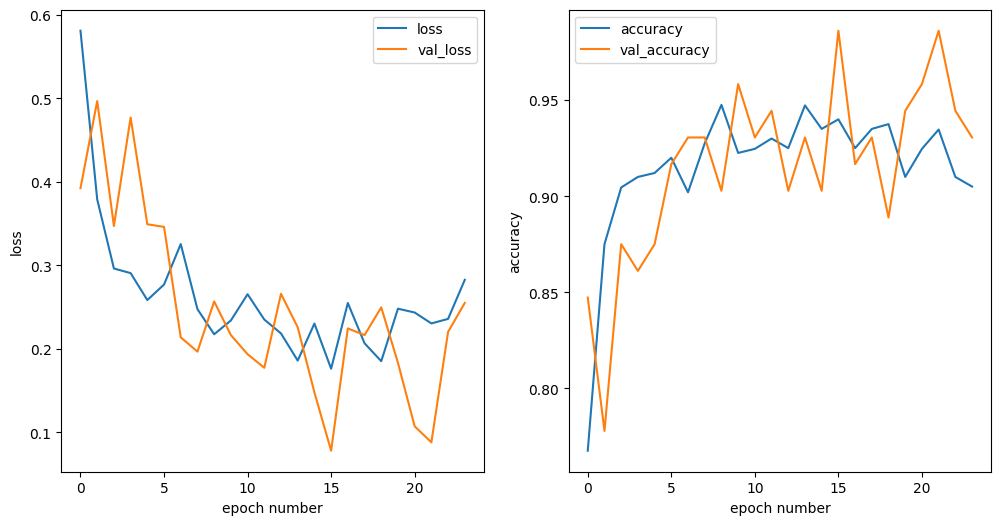

In [42]:
plot_loss_and_accuracy(model_history.history)

31/31 [==============================] - 0s 4ms/step
with_mask || with_mask


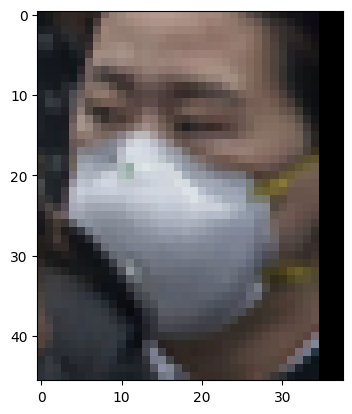

In [43]:
# predict
paths = test_generator.filenames
y_pred = model.predict(test_generator).argmax(axis=1)
classes = test_generator.class_indices

a_img_rand = np.random.randint(0,len(paths))
img = cv2.imread(os.path.join(output_data_path,'test', paths[a_img_rand]))      
colored_img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

plt.imshow(colored_img)
true_label = paths[a_img_rand].split('/')[0]
predicted_label = list(classes)[y_pred[a_img_rand]]
print(f'{predicted_label} || {true_label}')

In [44]:
# evaluation model
def evaluation(y, y_hat, title = 'Confusion Matrix'):
    cm = confusion_matrix(y, y_hat)
    sns.heatmap(cm,  cmap= 'PuBu', annot=True, fmt='g', annot_kws={'size':20})
    plt.xlabel('predicted', fontsize=18)
    plt.ylabel('actual', fontsize=18)
    plt.title(title, fontsize=18)
    
    plt.show()

31/31 [==============================] - 0s 4ms/step


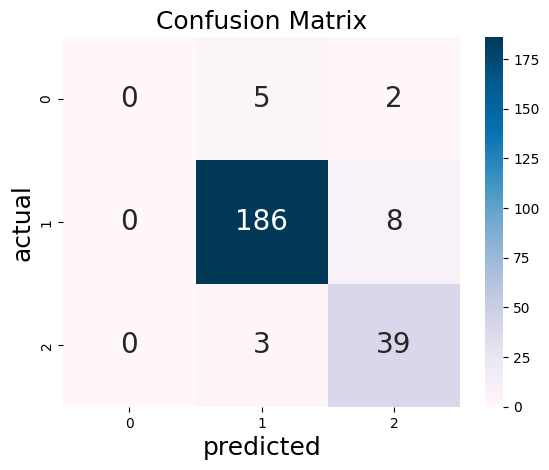

In [45]:
# Confusion Matrix

y_true = test_generator.labels
y_pred = model.predict(test_generator).argmax(axis=1) # Predict prob and get Class Indices

evaluation(y_true, y_pred)

In [46]:
display(classes)
np.bincount(y_pred)

{'mask_weared_incorrect': 0, 'with_mask': 1, 'without_mask': 2}

array([  0, 194,  49])

In [48]:
# Model Directory
directory = "Model"
  
# Parent Directory path
parent_dir = os.getcwd()
  
# Path
path = os.path.join(parent_dir, directory)
  
# Create the directory
# 'Model' in
# '/home/abdalrahman/Desktop/ProgressSoft/(Problem #2) Face Mask Detection'
os.mkdir(path)

In [49]:
# save model
model.save(path)

INFO:tensorflow:Assets written to: /home/abdalrahman/Desktop/ProgressSoft/(Problem #2) Face Mask Detection/Model/assets


INFO:tensorflow:Assets written to: /home/abdalrahman/Desktop/ProgressSoft/(Problem #2) Face Mask Detection/Model/assets
